In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
# Read hyperopt data
lines_start = 4200
lines_end = -1
df = pd.read_csv("../results/hyperopt.csv").iloc[lines_start:lines_end]

# Baseline
df_baseline = pd.read_csv("../results/data_clean.csv")
df_baseline["adapter"] = df_baseline["adapter"].fillna("no_adapter")

df.head(5)

,dataset,model,adapter,n_features,n_components,context_length,forecasting_horizon,num_layers,hidden_dim,learning_rate,...,num_coupling,scaled_mse,scaled_mae,test_scaled_mse,test_scaled_mae,use_revin,beta,train_size,training,p
4200,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,2.0,1.174343,0.842737,4.983773,1.519193,True,NaN,NaN,NaN,NaN
4201,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,2.0,1.782783,1.035557,6.971418,1.910941,True,NaN,NaN,NaN,NaN
4202,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,2.0,1.319664,0.847533,4.747558,1.584108,False,NaN,NaN,NaN,NaN
4203,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,2.0,1.312943,0.880307,5.351527,1.817441,False,NaN,NaN,NaN,NaN
4204,Illness_pred=24,AutonLab/MOMENT-1-small,flow,7.0,7.0,512.0,24.0,NaN,128.0,0.001,...,2.0,1.687735,0.995113,6.209709,1.764832,True,NaN,NaN,NaN,NaN


In [14]:
forecasting_horizon = 96
dataset_name = "ETTh2" + f"_pred={forecasting_horizon}"
model_name = "AutonLab/MOMENT-1-small"
adapter = "linearVAE"
n_components = 7
hypers = [
    # "hidden_dim",
    # "learning_rate",
    # "batch_size",
    # "num_coupling",
    # "num_layers",
    # "use_revin",
    "beta",
    # "p"
]

df_sub = df[
    (df["dataset"] == dataset_name)
    & (df["model"] == model_name)
    & (df["adapter"] == adapter)
    & (df["n_components"] == n_components)
]
df_baseline_sub = df_baseline[
    (df_baseline["dataset"] == dataset_name.split("_")[0])
    & (df_baseline["foundational_model"] == model_name)
    & (df_baseline["is_fine_tuned"] == "ft")
    & (df_baseline["adapter"] == "no_adapter")
]

df_sub.head(5)

,dataset,model,adapter,n_features,n_components,context_length,forecasting_horizon,num_layers,hidden_dim,learning_rate,...,num_coupling,scaled_mse,scaled_mae,test_scaled_mse,test_scaled_mae,use_revin,beta,train_size,training,p
4451,ETTh2_pred=96,AutonLab/MOMENT-1-small,linearVAE,7.0,7.0,512.0,96.0,NaN,NaN,0.001,...,NaN,0.396840,0.380905,0.930819,0.700891,True,2.0,500.0,full,NaN
4452,ETTh2_pred=96,AutonLab/MOMENT-1-small,linearVAE,7.0,7.0,512.0,96.0,NaN,NaN,0.001,...,NaN,0.369673,0.374423,0.889259,0.691552,True,1.0,500.0,full,NaN
4453,ETTh2_pred=96,AutonLab/MOMENT-1-small,linearVAE,7.0,7.0,512.0,96.0,NaN,NaN,0.001,...,NaN,0.307137,0.343598,0.916337,0.687581,True,0.5,500.0,full,NaN
4458,ETTh2_pred=96,AutonLab/MOMENT-1-small,linearVAE,7.0,7.0,512.0,96.0,NaN,NaN,0.001,...,NaN,0.461146,0.397995,0.912798,0.702234,True,4.0,500.0,full,NaN
4462,ETTh2_pred=96,AutonLab/MOMENT-1-small,linearVAE,7.0,7.0,512.0,96.0,NaN,NaN,0.001,...,NaN,0.335819,0.354049,0.928520,0.696089,True,4.0,500.0,full,NaN


In [15]:
df_baseline_clean = df_baseline_sub.drop(
    columns=[
        "dataset",
        "foundational_model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
        "is_fine_tuned",
    ],
    inplace=False,
)
df_clean = df_sub.drop(
    columns=[
        "dataset",
        "model",
        "adapter",
        "n_features",
        "forecasting_horizon",
        "n_components",
        "context_length",
    ],
    inplace=False,
)
df_clean = df_clean.loc[:, df_clean.nunique() != 1]
df_clean = df_clean.dropna(axis=1, how="all")
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains("scaled")]
df_clean = df_clean.dropna()
df_clean.head(5)

,running_time,mse,mae,test_mse,test_mae,beta
4451,2486.240544,0.404625,0.386146,0.332879,0.391128,2.0
4452,2790.335388,0.404435,0.391220,0.324261,0.387568,1.0
4453,2855.343811,0.335528,0.358735,0.331873,0.386710,0.5
4458,3021.798737,0.512785,0.418995,0.339933,0.399083,4.0
4462,3142.019696,0.330082,0.356907,0.349005,0.396337,4.0


In [16]:
df_baseline_clean.head(5)

,pca_in_preprocessing,use_revin,running_time,seed,metric,value,train_size
2330,False,False,175.264803,29521.0,mse,0.303091,1000.0
2331,False,False,175.264803,29521.0,mae,0.359312,1000.0
2332,False,False,175.264803,29521.0,scaled_mse,0.304659,1000.0
2333,False,False,175.264803,29521.0,scaled_mae,0.359507,1000.0
2334,False,False,175.880579,31579.0,mse,0.302031,1000.0


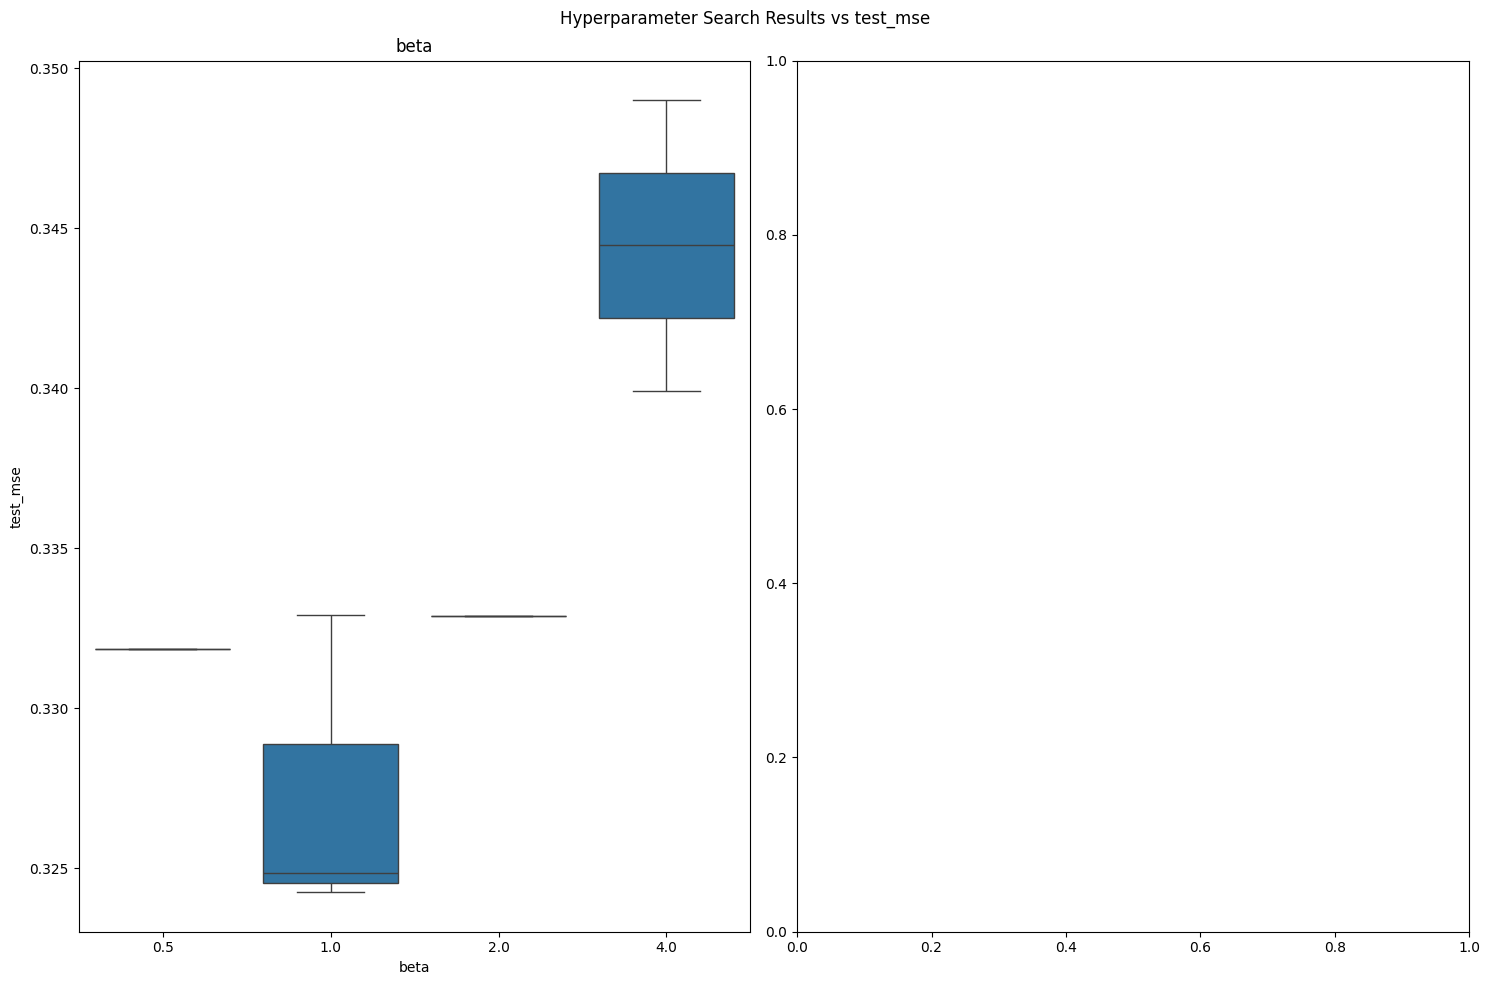

In [17]:
metric = "test_mse"

# Create subplots for each hyperparameter
fig, axes = plt.subplots(len(hypers) // 2 + len(hypers) % 2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

for i, hyper in enumerate(hypers):
    if hyper in df_clean.columns:
        sns.boxplot(data=df_clean, x=hyper, y=metric, ax=axes[i])
    axes[i].set_title(hyper)

plt.tight_layout()
plt.show()

In [18]:
# Group by the hyperparameters and calculate mean and std for each metric
grouped_df = df_clean.groupby(hypers).agg(["mean", "std", "count"])

# Flatten the MultiIndex columns
grouped_df.columns = ["_".join(col).strip() for col in grouped_df.columns.values]

grouped_df.reset_index(inplace=True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[metric: mse]
beta    0.5
Name: 0, dtype: float64
 0.3318727297867335+-nan  
---

[metric: mae]
beta    0.5
Name: 0, dtype: float64
 0.3318727297867335+-nan  
---

[metric: test_mse]
beta    1.0
Name: 1, dtype: float64
 0.32734402362753606+-0.0027958620144733007  
---

baseline(test_mse): 0.30388411706130763 +- 0.0010062352017194457
[metric: test_mae]
beta    1.0
Name: 1, dtype: float64
 0.32734402362753606+-0.0027958620144733007  
---

baseline(test_mae): 0.3599230126732532 +- 0.0007058749117636565


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


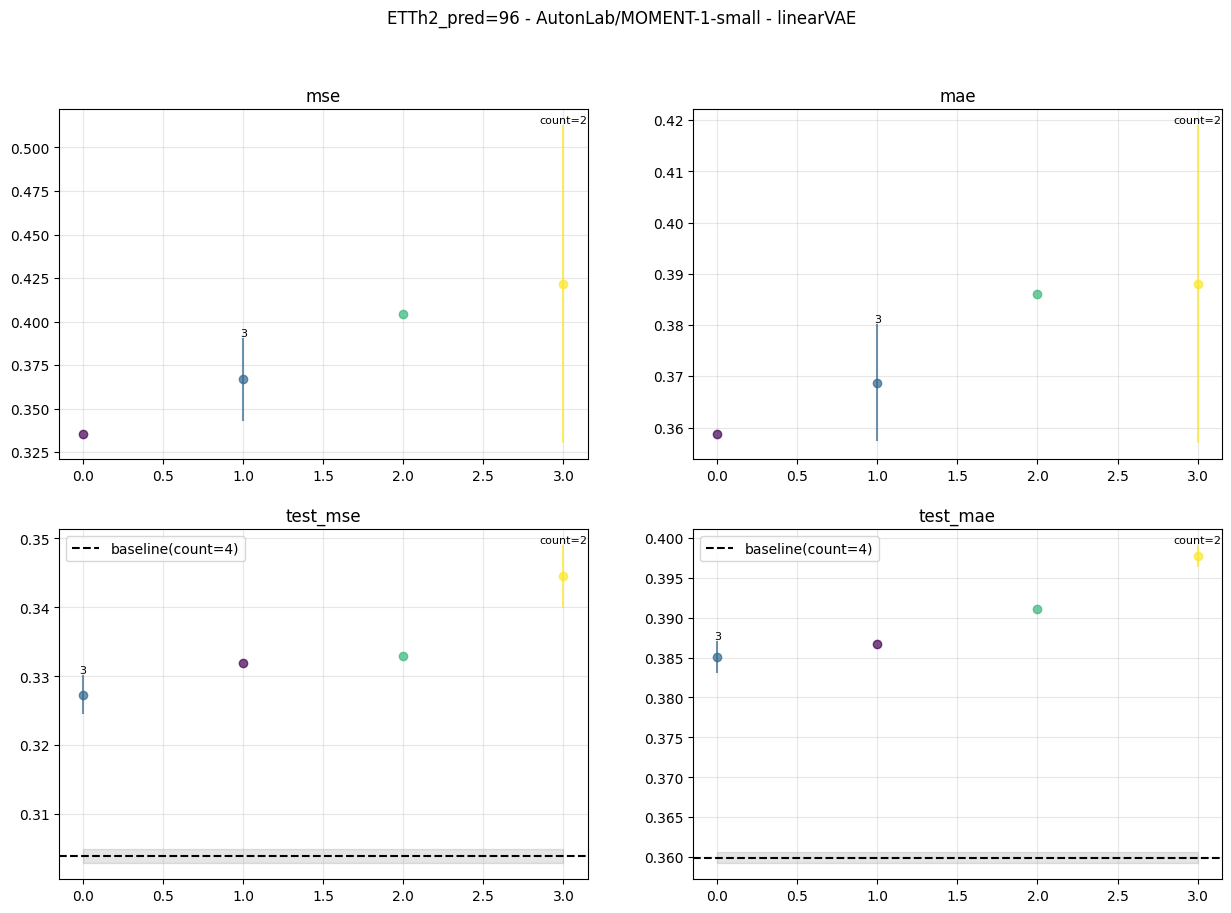

,beta,running_time_mean,running_time_std,running_time_count,mse_mean,mse_std,mse_count,mae_mean,mae_std,mae_count,test_mse_mean,test_mse_std,test_mse_count,test_mae_mean,test_mae_std,test_mae_count
0,0.5,2855.343811,NaN,1,0.335528,NaN,1,0.358735,NaN,1,0.331873,NaN,1,0.386710,NaN,1
1,1.0,3152.948756,322.589627,3,0.366762,0.041042,3,0.368750,0.019754,3,0.327344,0.004843,3,0.385070,0.003486,3
2,2.0,2486.240544,NaN,1,0.404625,NaN,1,0.386146,NaN,1,0.332879,NaN,1,0.391128,NaN,1
3,4.0,3081.909216,85.009055,2,0.421433,0.129191,2,0.387951,0.043903,2,0.344469,0.006415,2,0.397710,0.001942,2


In [19]:
top_k = 100
metrics = ["mse", "mae", "test_mse", "test_mae"]
fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(15, 10))
fig.suptitle(f"{dataset_name} - {model_name} - {adapter}")
axes = axes.flatten()

# Create a color map based on initial rankings for mse
num_configs = len(grouped_df)
colors = plt.cm.viridis(np.linspace(0, 1, num_configs))

# Get initial ranking order based on mse
initial_order = grouped_df.sort_values(by="mse_mean").index
color_dict = dict(zip(initial_order, colors))

for i, metric in enumerate(metrics):
    # Sort by the specified metric mean
    sorted_df = grouped_df.sort_values(by=f"{metric}_mean", ascending=True)
    # Keep only top 12 configurations
    sorted_df = sorted_df.head(top_k)
    if metric == "mse":
        keep_sorted_df = sorted_df.copy()

    print(
        f"[metric: {metric}]\n{sorted_df.iloc[0][hypers]}\n {sorted_df.iloc[0]['test_mse_mean']}+-{sorted_df.iloc[0]['test_mse_std'] / np.sqrt(sorted_df.iloc[0]['test_mse_count'])}  \n---\n"
    )

    # Plot points with error bars using consistent colors
    size = len(sorted_df)
    for idx, row in sorted_df.iterrows():
        axes[i].errorbar(
            x=sorted_df.index.get_loc(idx),
            y=row[f"{metric}_mean"],
            yerr=row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            fmt="o",
            color=color_dict[idx],
            alpha=0.7,
        )
        ct = int(row[f"{metric}_count"])
        axes[i].text(
            sorted_df.index.get_loc(idx),
            row[f"{metric}_mean"]
            + row[f"{metric}_std"] / np.sqrt(row[f"{metric}_count"]),
            f"count={ct}" if idx == size - 1 else str(ct),
            fontsize=8,
            ha="center",
            va="bottom",
        )

    # baseline
    if "test" in metric:
        values = df_baseline_clean.loc[df_baseline_clean["metric"] == metric[5:]][
            "value"
        ]
        baseline = values.mean()
        baseline_std = values.std()
        print(
            f"baseline({metric}): {baseline} +- {baseline_std / np.sqrt(len(values))}"
        )
        x_range = [0, len(sorted_df) - 1]
        axes[i].axhline(
            y=baseline,
            color="black",
            linestyle="--",
            label=f"baseline(count={len(values)})",
        )
        axes[i].fill_between(
            x_range,
            [baseline - baseline_std / np.sqrt(len(values))],
            [baseline + baseline_std / np.sqrt(len(values))],
            color="black",
            alpha=0.1,
        )
        axes[i].legend()

    axes[i].set_title(metric)
    axes[i].grid(True, alpha=0.3)
plt.show()
keep_sorted_df

In [10]:
from dicl.utils.main_script import prepare_data

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="Illness_pred=24", context_length=512, forecasting_horizon=24
)
print(
    f"Illness_pred=24, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

Illness_pred=24, size: (141, 7, 512), val size (74, 7, 512), test size (170, 7, 512)


In [13]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="ETTh1_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"ETTh1_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

ETTh1_pred=96, size: (8033, 7, 512), val size (2785, 7, 512), test size (2785, 7, 512)


In [14]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="Weather_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"Weather_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

Weather_pred=96, size: (36280, 21, 512), val size (5175, 21, 512), test size (10444, 21, 512)


In [15]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="ExchangeRate_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"ExchangeRate_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

ExchangeRate_pred=96, size: (4704, 8, 512), val size (665, 8, 512), test size (1422, 8, 512)


In [16]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="ETTh2_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"ETTh2_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

ETTh2_pred=96, size: (8033, 7, 512), val size (2785, 7, 512), test size (2785, 7, 512)


In [17]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="ETTm1_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"ETTm1_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

ETTm1_pred=96, size: (33953, 7, 512), val size (11425, 7, 512), test size (11425, 7, 512)


In [18]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="Traffic_pred=96", context_length=512, forecasting_horizon=96
)
print(
    f"Traffic_pred=96, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

Traffic_pred=96, size: (11673, 862, 512), val size (1661, 862, 512), test size (3413, 862, 512)
